In [1]:
#Importing necessary libraries
import pandas as pd
import numpy as np 
from matplotlib import pyplot as plt
import seaborn as sns
import tensorflow as tf
from sklearn.model_selection import train_test_split
import librosa
import os
import shap
import librosa.display
from skimage.io import imread
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.tree import export_text
from sklearn.inspection import permutation_importance

C:\Users\19147\anaconda3\Lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


In [2]:
import pandas as pd

# Load the CSV file
metadata_path = "C:/Users/19147/Downloads/archive (12)/bird_songs_metadata.csv"
df = pd.read_csv(metadata_path)

# Display the first few rows of the dataframe 
df.head()


,id,genus,species,subspecies,name,recordist,country,location,latitude,longitude,altitude,sound_type,source_url,license,time,date,remarks,filename
0,557838,Thryomanes,bewickii,NaN,Bewick's Wren,Whitney Neufeld-Kaiser,United States,"Arlington, Snohomish County, Washington",48.0708,-122.1006,100,"adult, sex uncertain, song",//www.xeno-canto.org/557838,//creativecommons.org/licenses/by-nc-sa/4.0/,11:51,2020-03-14,"Recorded with Voice Record Pro on iPhone7, nor...",557838-0.wav
1,557838,Thryomanes,bewickii,NaN,Bewick's Wren,Whitney Neufeld-Kaiser,United States,"Arlington, Snohomish County, Washington",48.0708,-122.1006,100,"adult, sex uncertain, song",//www.xeno-canto.org/557838,//creativecommons.org/licenses/by-nc-sa/4.0/,11:51,2020-03-14,"Recorded with Voice Record Pro on iPhone7, nor...",557838-1.wav
2,557838,Thryomanes,bewickii,NaN,Bewick's Wren,Whitney Neufeld-Kaiser,United States,"Arlington, Snohomish County, Washington",48.0708,-122.1006,100,"adult, sex uncertain, song",//www.xeno-canto.org/557838,//creativecommons.org/licenses/by-nc-sa/4.0/,11:51,2020-03-14,"Recorded with Voice Record Pro on iPhone7, nor...",557838-4.wav
3,557838,Thryomanes,bewickii,NaN,Bewick's Wren,Whitney Neufeld-Kaiser,United States,"Arlington, Snohomish County, Washington",48.0708,-122.1006,100,"adult, sex uncertain, song",//www.xeno-canto.org/557838,//creativecommons.org/licenses/by-nc-sa/4.0/,11:51,2020-03-14,"Recorded with Voice Record Pro on iPhone7, nor...",557838-5.wav
4,557838,Thryomanes,bewickii,NaN,Bewick's Wren,Whitney Neufeld-Kaiser,United States,"Arlington, Snohomish County, Washington",48.0708,-122.1006,100,"adult, sex uncertain, song",//www.xeno-canto.org/557838,//creativecommons.org/licenses/by-nc-sa/4.0/,11:51,2020-03-14,"Recorded with Voice Record Pro on iPhone7, nor...",557838-6.wav


In [3]:
#distribution of species
species_dist = df['species'].value_counts()
print(species_dist)

species
melodia        1256
polyglottos    1182
cardinalis     1074
migratorius    1017
bewickii        893
Name: count, dtype: int64


In [4]:
# Checking for missing values in each column
missing_values = df.isnull().sum()
print(missing_values)

id               0
genus            0
species          0
subspecies    3876
name             0
recordist        0
country          0
location         0
latitude        90
longitude       90
altitude        42
sound_type       0
source_url       0
license          0
time             0
date             0
remarks       1859
filename         0
dtype: int64


The primary input for generating spectrograms is the audio file itself. Missing values in metadata (like subspecies, latitude, longitude, altitude, and remarks) won't affect the generation of spectrograms, as long as the audio files (filename) are intact and not missing. 

In [5]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5422 entries, 0 to 5421
Data columns (total 18 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   id          5422 non-null   int64  
 1   genus       5422 non-null   object 
 2   species     5422 non-null   object 
 3   subspecies  1546 non-null   object 
 4   name        5422 non-null   object 
 5   recordist   5422 non-null   object 
 6   country     5422 non-null   object 
 7   location    5422 non-null   object 
 8   latitude    5332 non-null   float64
 9   longitude   5332 non-null   float64
 10  altitude    5380 non-null   object 
 11  sound_type  5422 non-null   object 
 12  source_url  5422 non-null   object 
 13  license     5422 non-null   object 
 14  time        5422 non-null   object 
 15  date        5422 non-null   object 
 16  remarks     3563 non-null   object 
 17  filename    5422 non-null   object 
dtypes: float64(2), int64(1), object(15)
memory usage: 762.6+ KB
None


**Feature Extraction**

In [6]:

def load_bird_sound_paths_from_csv(metadata_path, audio_files_path):
    df = pd.read_csv(metadata_path)
    file_paths = []
    labels = []

    for index, row in df.iterrows():
        file_path = os.path.join(audio_files_path, row['filename'])
        if os.path.exists(file_path):
            file_paths.append(file_path)
            labels.append(row['species'])  # 'species' holds the label
        else:
            print(f"File not found: {file_path}")

    return file_paths, labels

# Usage
metadata_path = "C:/Users/19147/Downloads/archive (12)/bird_songs_metadata.csv"
audio_files_path =  "C:/Users/19147/Downloads/archive (12)/wavfiles"

file_paths, labels = load_bird_sound_paths_from_csv(metadata_path, audio_files_path)
print(file_paths[:5], labels[:5])


['C:/Users/19147/Downloads/archive (12)/wavfiles\\557838-0.wav', 'C:/Users/19147/Downloads/archive (12)/wavfiles\\557838-1.wav', 'C:/Users/19147/Downloads/archive (12)/wavfiles\\557838-4.wav', 'C:/Users/19147/Downloads/archive (12)/wavfiles\\557838-5.wav', 'C:/Users/19147/Downloads/archive (12)/wavfiles\\557838-6.wav'] ['bewickii', 'bewickii', 'bewickii', 'bewickii', 'bewickii']


In [7]:
# New function to load and process audio files from paths
def load_and_process_audio(file_paths, sr, fixed_length):
    processed_audio = []
    for file_path in file_paths:
        sound, _ = librosa.load(file_path, sr=sr)
        if len(sound) > fixed_length:
            sound = sound[:fixed_length]
        else:
            padding = fixed_length - len(sound)
            sound = np.pad(sound, (0, padding), 'constant')
        processed_audio.append(sound)
    return processed_audio

In [8]:

# Encode labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(labels)

In [9]:
def extract_waveform_features(file_path):
    audio, sr = librosa.load(file_path, sr=None)  # Load audio with its native sampling rate
    rms = librosa.feature.rms(y=audio).flatten()  # Root Mean Square feature
    zcr = librosa.feature.zero_crossing_rate(y=audio).flatten()  # Zero Crossing Rate feature
    combined_features = np.concatenate((rms, zcr))  # Combine features into a single array
    return combined_features, sr  # Return features and sampling rate

In [10]:
# Extract features from all files
waveform_features_list = []
sampling_rates = []
for file_path in file_paths:
    features, sr = extract_waveform_features(file_path)
    waveform_features_list.append(features)
    sampling_rates.append(sr)

In [11]:
# Convert list to numpy array for further processing
waveform_features_array = np.array(waveform_features_list)

In [12]:
X2_train, X2_test, y2_train, y2_test, files2_train, files2_test = train_test_split(
    waveform_features_array, y_encoded, file_paths, test_size=0.2, random_state=42
)

# Initialize and train the RandomForest classifier
clf_waveform = RandomForestClassifier(random_state=42)
clf_waveform.fit(X2_train, y2_train)

# Make predictions
clf_waveform_predictions = clf_waveform.predict(X2_test)

# Print accuracy and classification report
print(f"Accuracy with waveform features: {accuracy_score(y2_test, clf_waveform_predictions)}")
print(f"Classification Report: {classification_report(y2_test, clf_waveform_predictions, target_names=label_encoder.classes_)}")

Accuracy with waveform features: 0.7041474654377881
Classification Report:               precision    recall  f1-score   support

    bewickii       0.72      0.71      0.72       193
  cardinalis       0.64      0.75      0.69       204
     melodia       0.68      0.78      0.73       243
 migratorius       0.80      0.64      0.71       207
 polyglottos       0.71      0.65      0.68       238

    accuracy                           0.70      1085
   macro avg       0.71      0.70      0.70      1085
weighted avg       0.71      0.70      0.70      1085



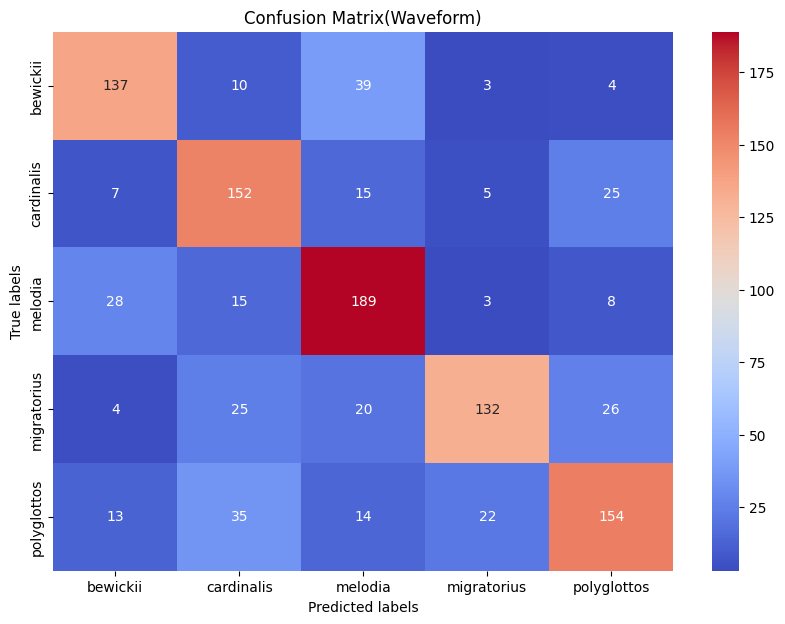

[[137  10  39   3   4]
 [  7 152  15   5  25]
 [ 28  15 189   3   8]
 [  4  25  20 132  26]
 [ 13  35  14  22 154]]


In [13]:
cm_waveform = confusion_matrix(y2_test,clf_waveform_predictions)

# Plotting using seaborn 
plt.figure(figsize=(10, 7))
sns.heatmap(cm_waveform, annot=True, fmt='g', cmap='coolwarm', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix(Waveform)')
plt.show()
print(cm_waveform)

In [16]:
waveform_probs = clf_waveform.predict_proba(X2_test)
max_probs_waveform = np.max(waveform_probs, axis=1)

# Top 10 indices for highest confidence predictions
waveform_top_indices = np.argsort(-max_probs_waveform)[:10]
print("Waveform top indices:", waveform_top_indices)

# Bottom 10 indices for lowest confidence predictions
waveform_bottom_indices = np.argsort(max_probs_waveform)[:10]
print("Waveform bottom indices:", waveform_bottom_indices)

# Incorrect predictions indices
waveform_incorrect_indices = np.where(clf_waveform_predictions != y2_test)[0]
print("Waveform incorrect indices:", waveform_incorrect_indices)


Waveform top indices: [ 85 219 328  30 850 813  66 903 997  54]
Waveform bottom indices: [ 517  857 1067  111  720  601  830  154  736  414]
Waveform incorrect indices: [   7    8    9   15   20   21   26   29   34   35   37   44   46   49
   52   58   62   67   68   70   75   78   82   86   91   94  100  106
  107  109  110  111  117  120  122  123  126  127  128  129  130  132
  135  136  141  143  151  153  154  155  158  159  162  166  171  173
  179  182  187  188  189  190  191  192  198  201  206  218  233  238
  246  247  249  251  254  262  264  267  269  272  273  275  277  279
  280  281  284  290  295  299  302  307  308  321  326  327  331  333
  334  346  351  361  364  367  368  369  370  374  378  383  389  391
  396  398  399  405  406  410  412  413  414  417  418  438  442  443
  446  451  454  455  456  459  472  473  475  476  485  486  490  493
  500  505  507  514  515  517  522  523  531  532  533  542  543  546
  551  552  553  555  556  558  562  564  570  575

In [17]:
def plot_combined_features(features, title):
    rms_length = len(features) // 2
    rms = features[:rms_length]
    zcr = features[rms_length:]

    # Plot RMS
    plt.figure(figsize=(12, 4))
    plt.plot(rms)
    plt.title(f'RMS of {title}')
    plt.xlabel('Frame')
    plt.ylabel('Amplitude')
    plt.show()

    # Plot ZCR
    plt.figure(figsize=(12, 4))
    plt.plot(zcr)
    plt.title(f'ZCR of {title}')
    plt.xlabel('Frame')
    plt.ylabel('Rate')
    plt.show()


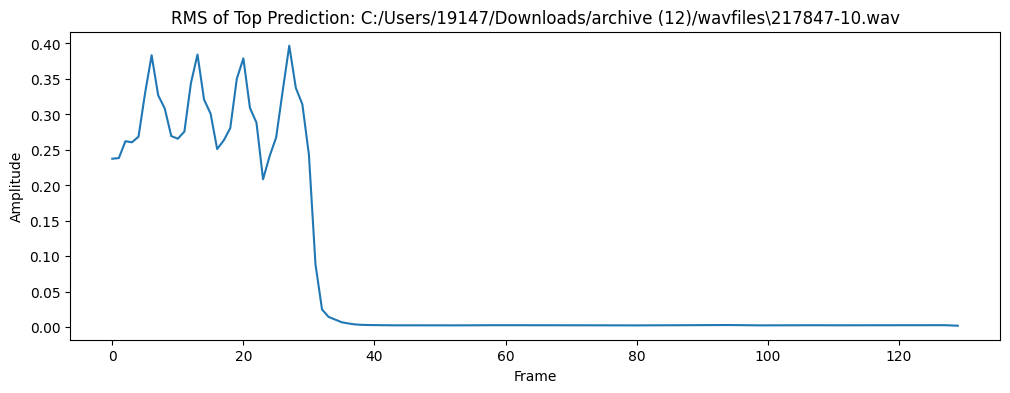

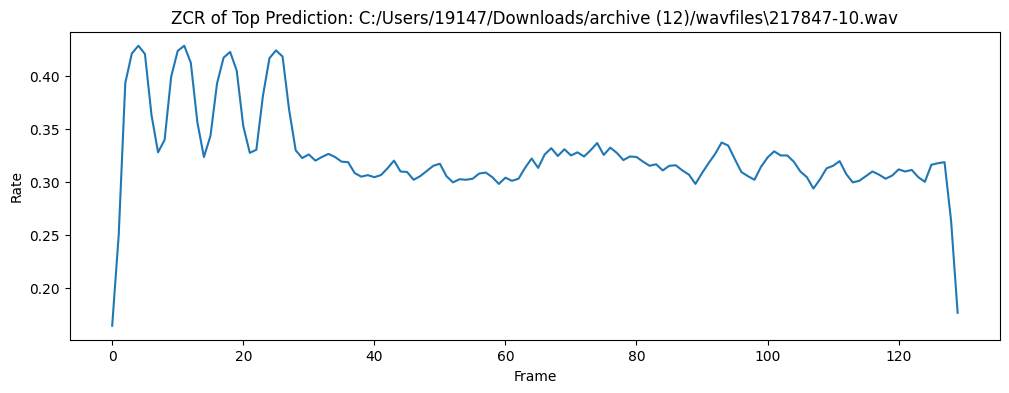

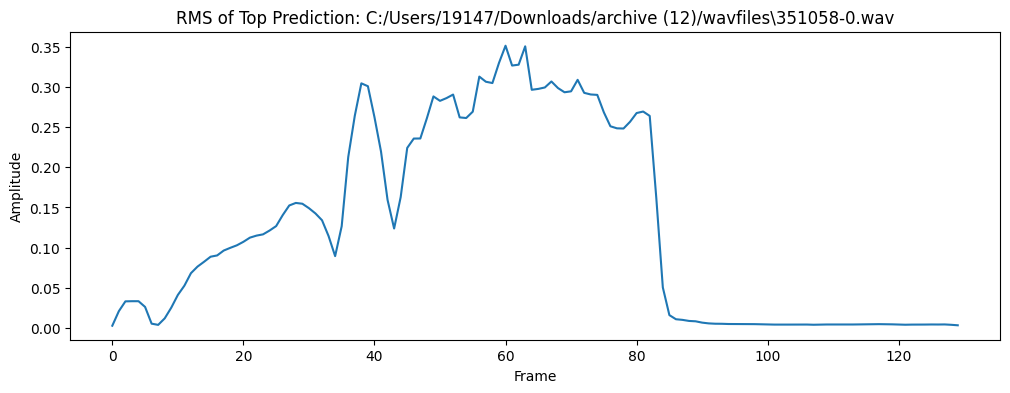

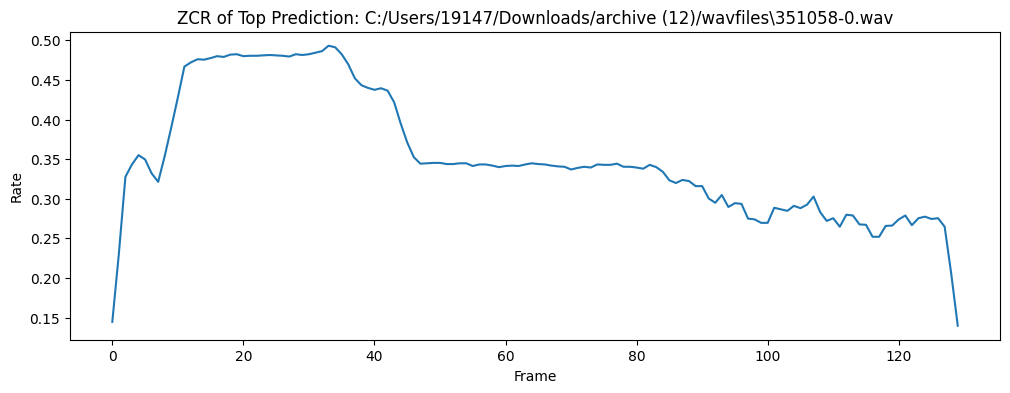

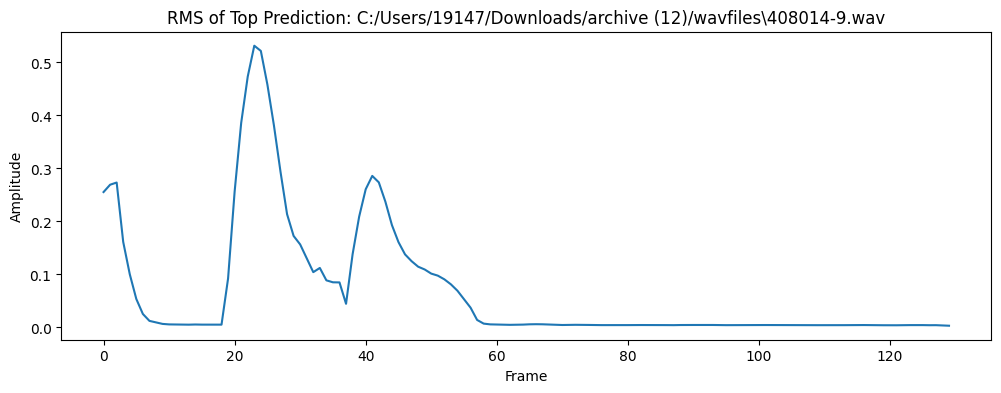

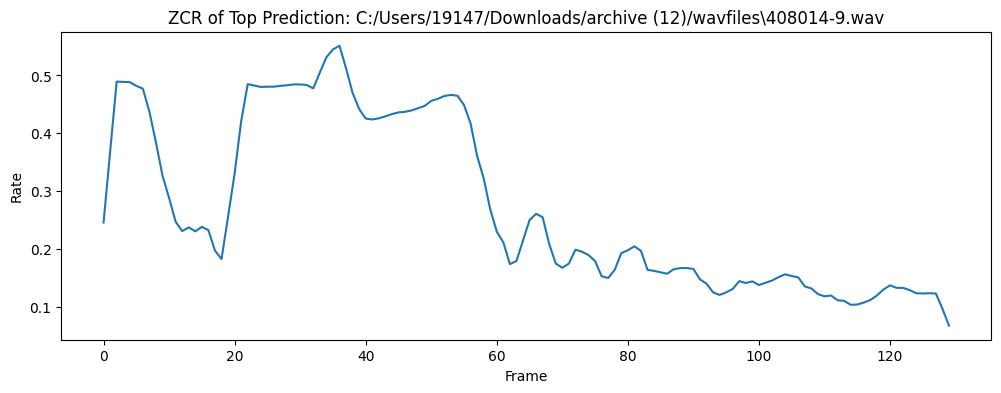

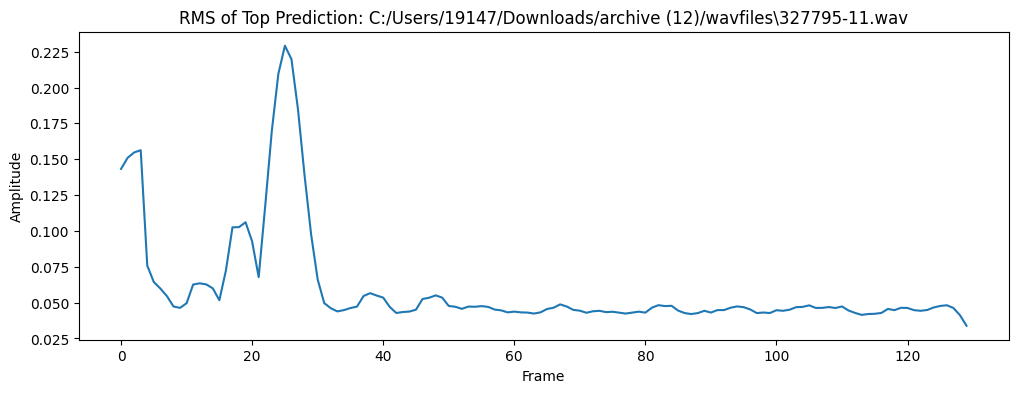

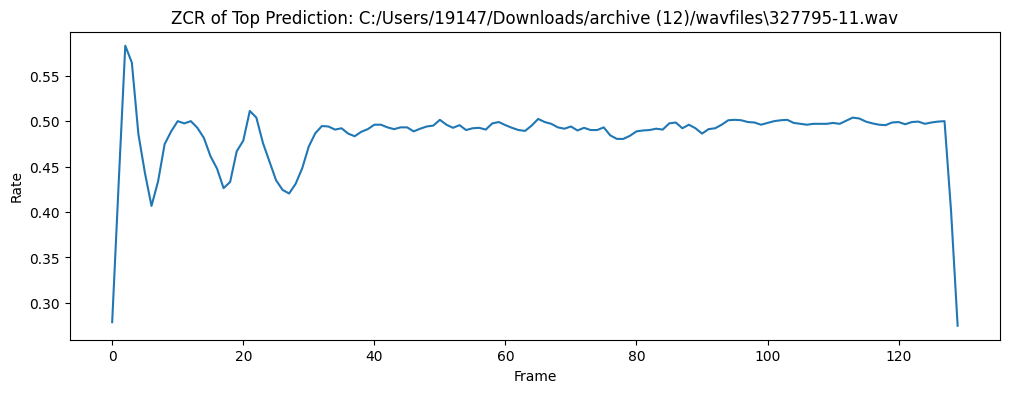

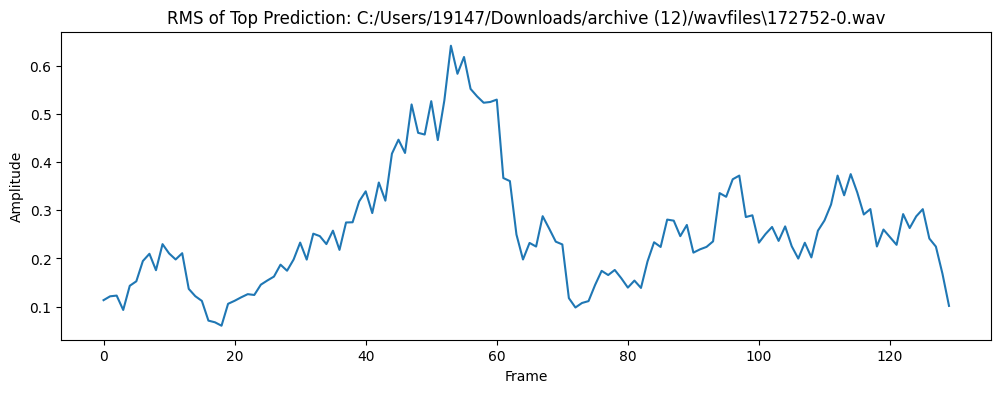

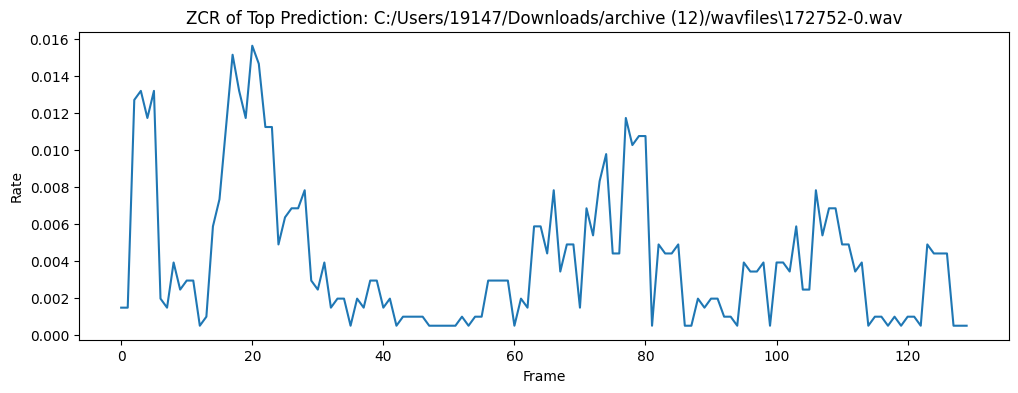

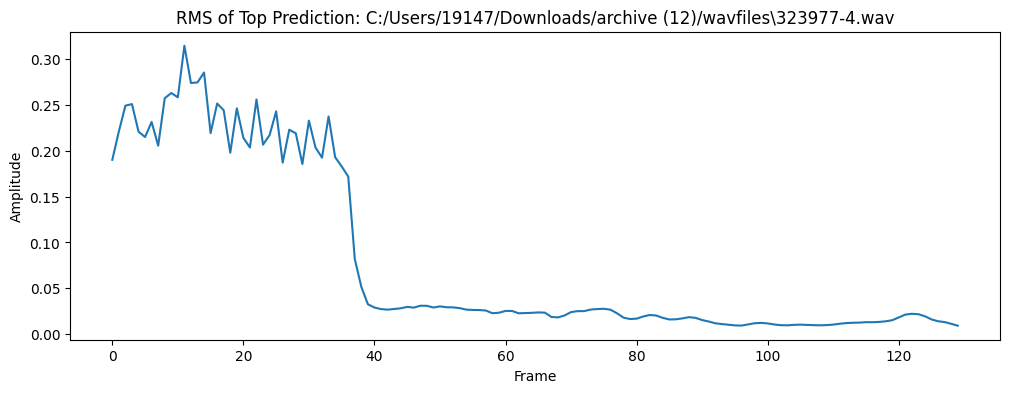

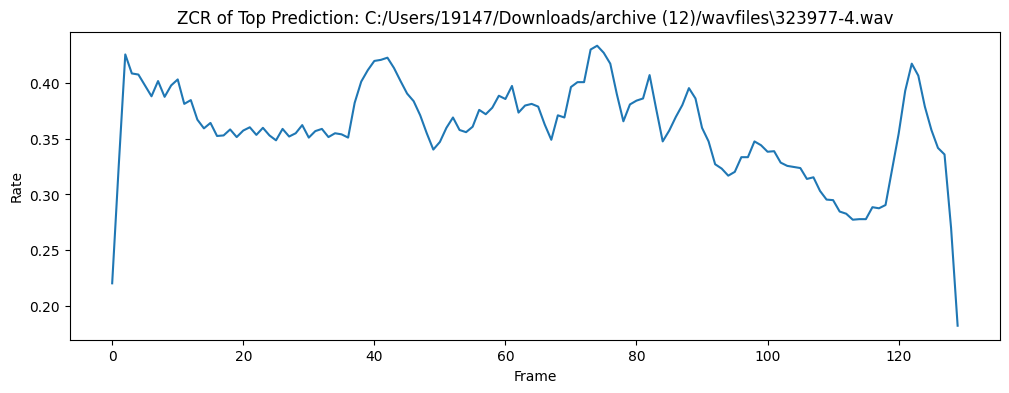

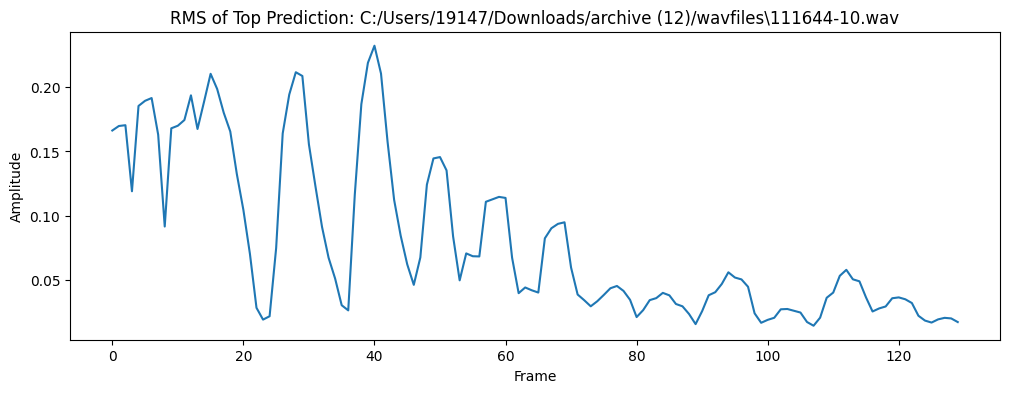

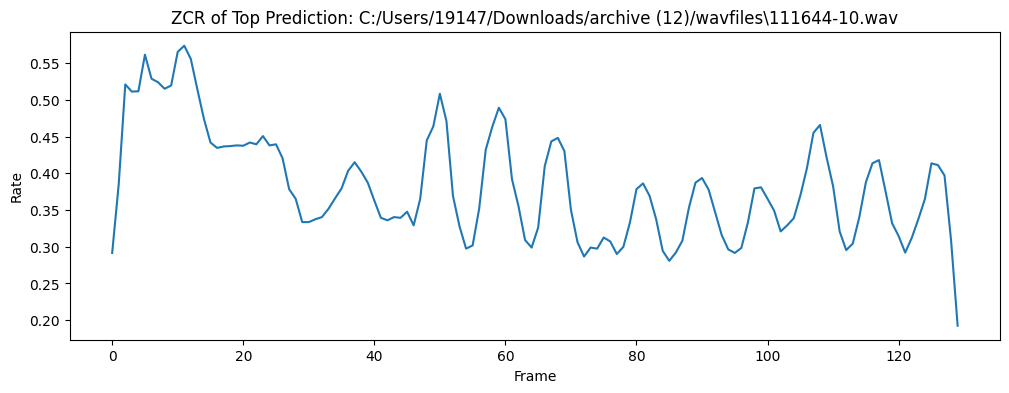

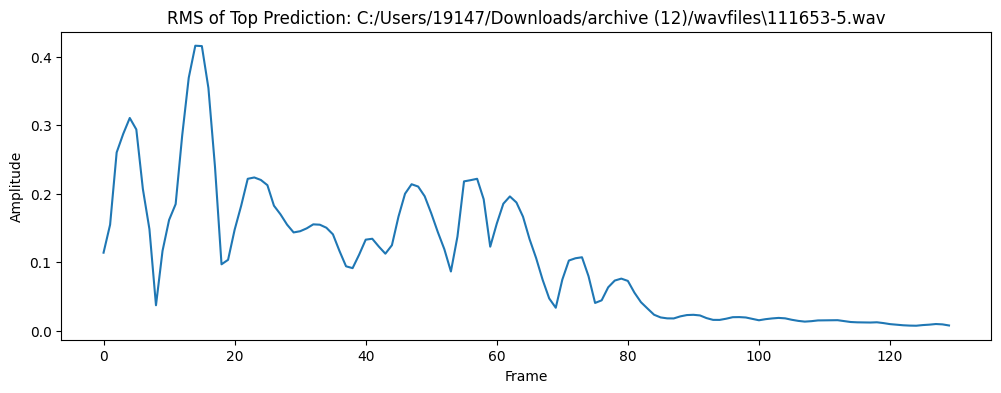

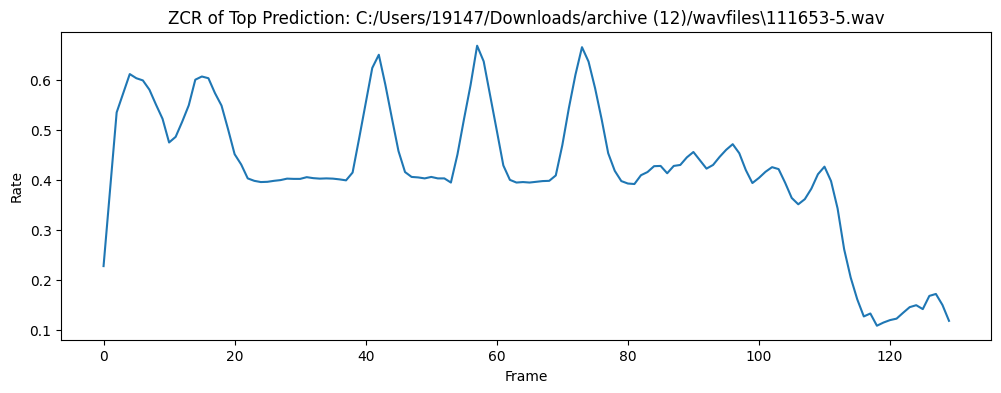

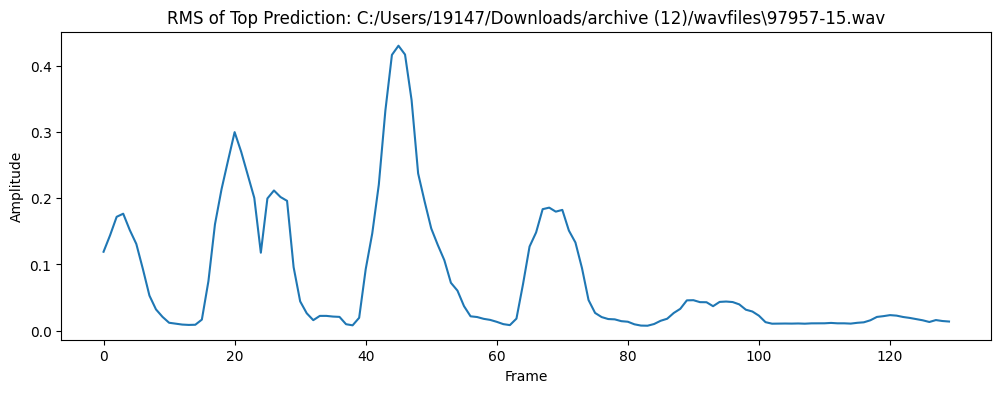

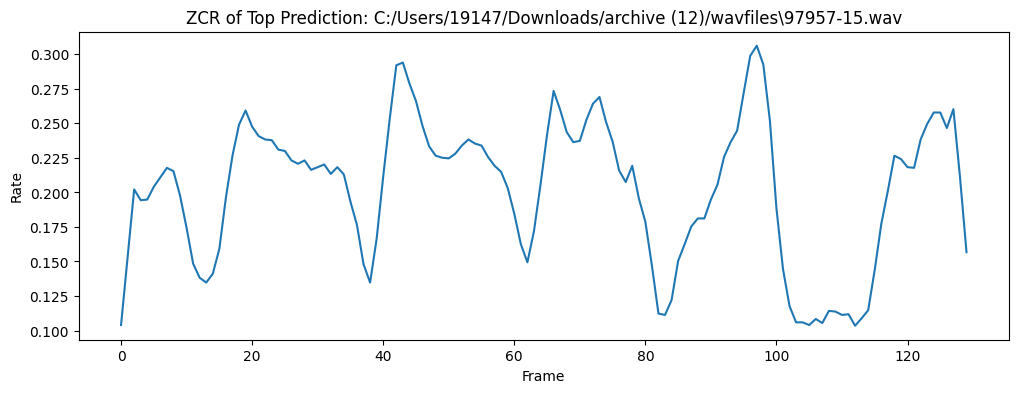

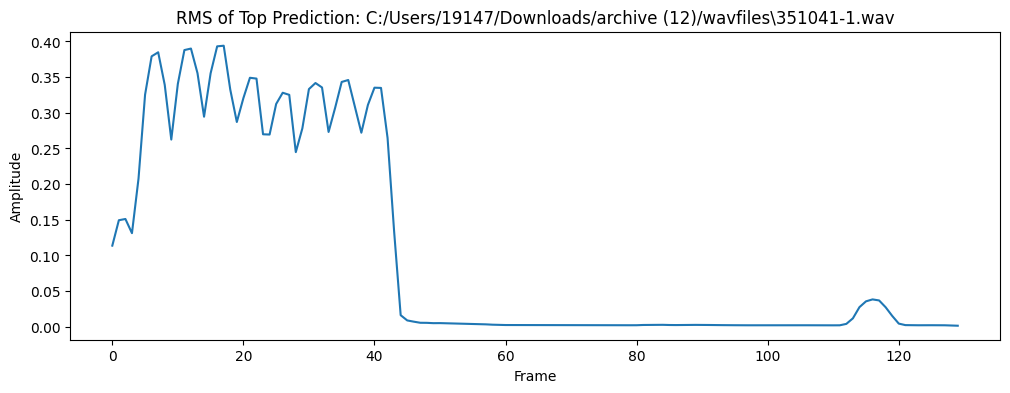

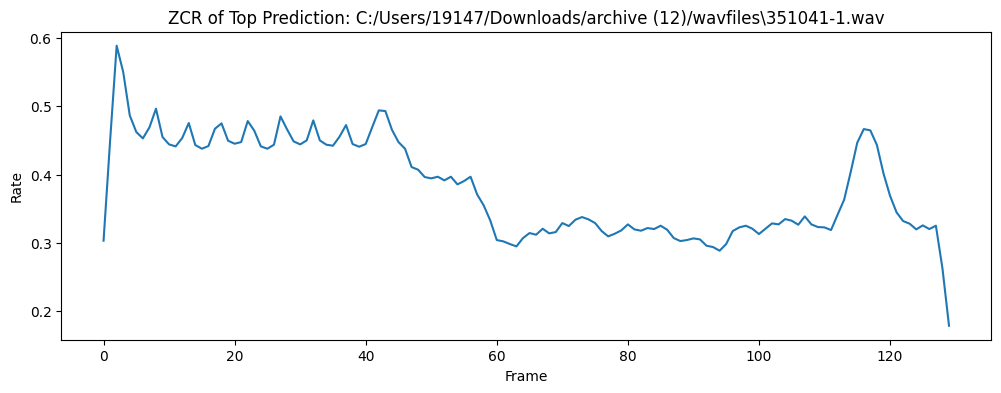

In [18]:
# Top Predictions
for index in waveform_top_indices:
    features = X2_test[index]
    file_path = files2_test[index]
    plot_combined_features(features, f'Top Prediction: {file_path}')



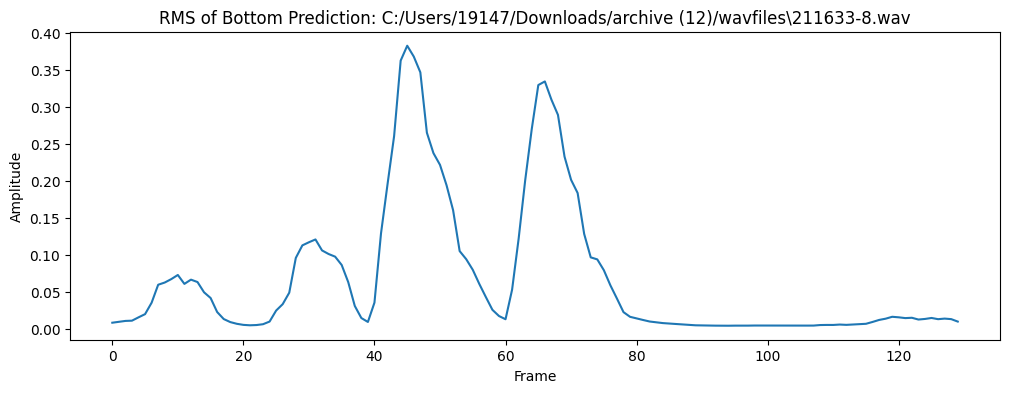

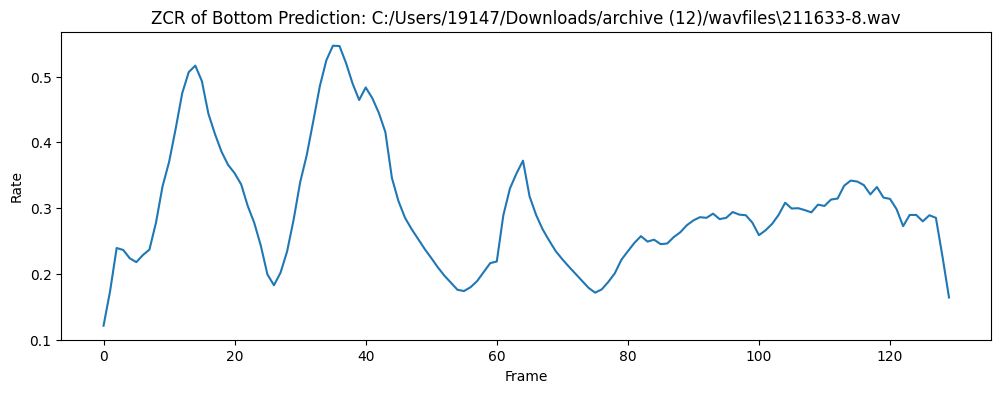

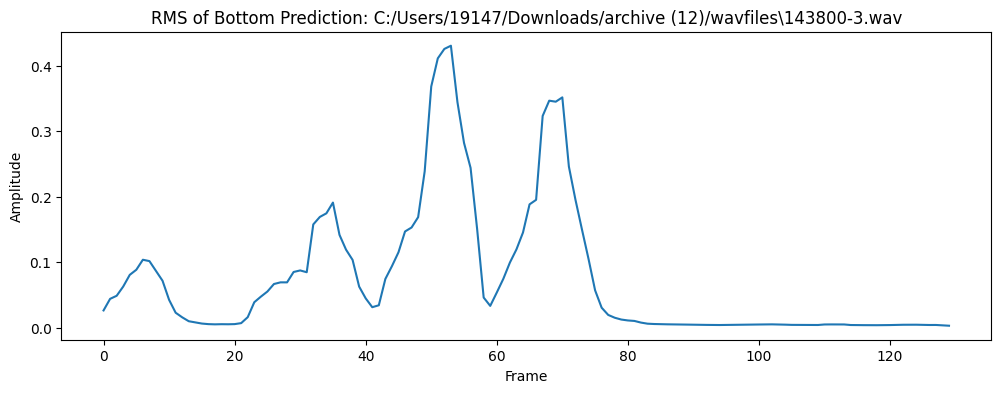

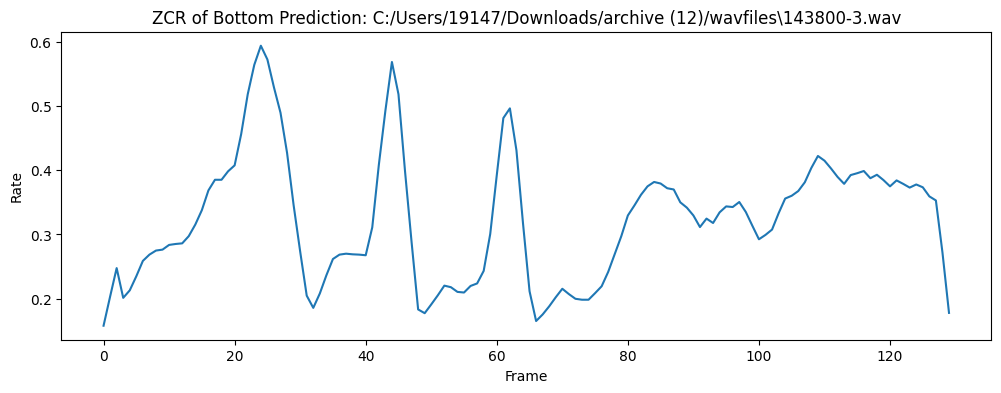

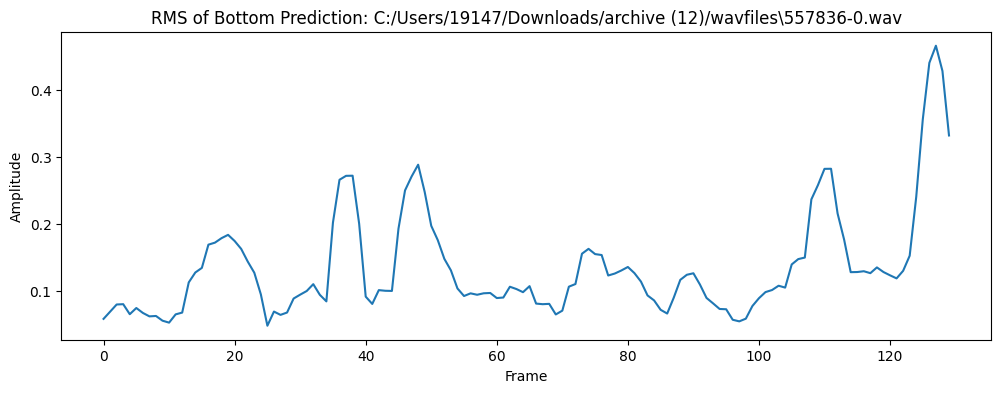

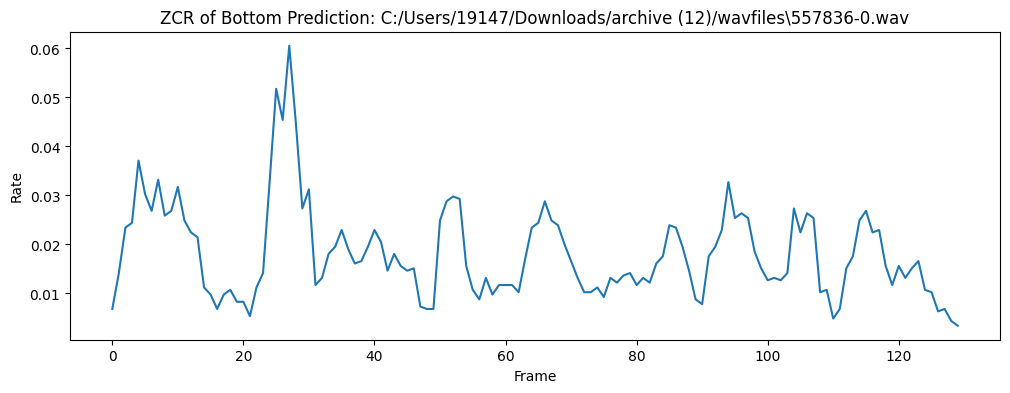

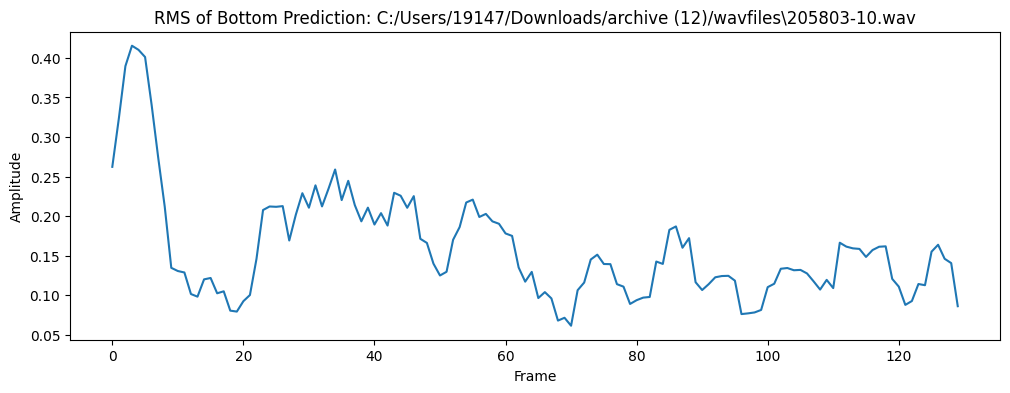

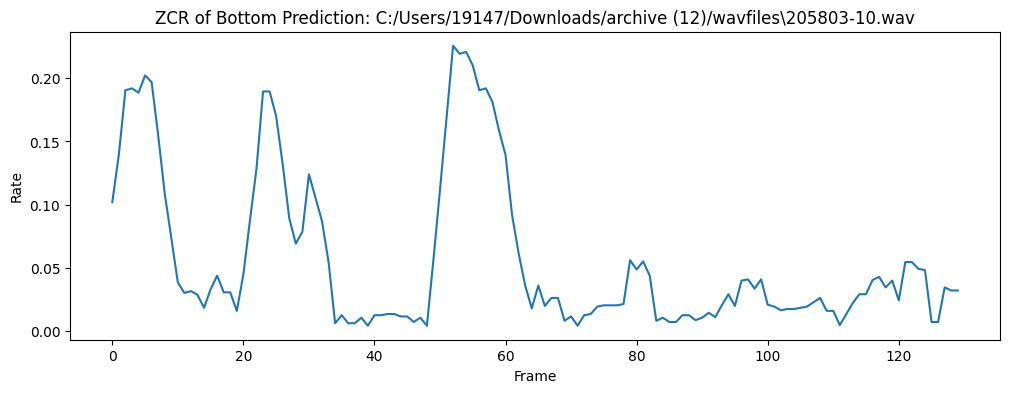

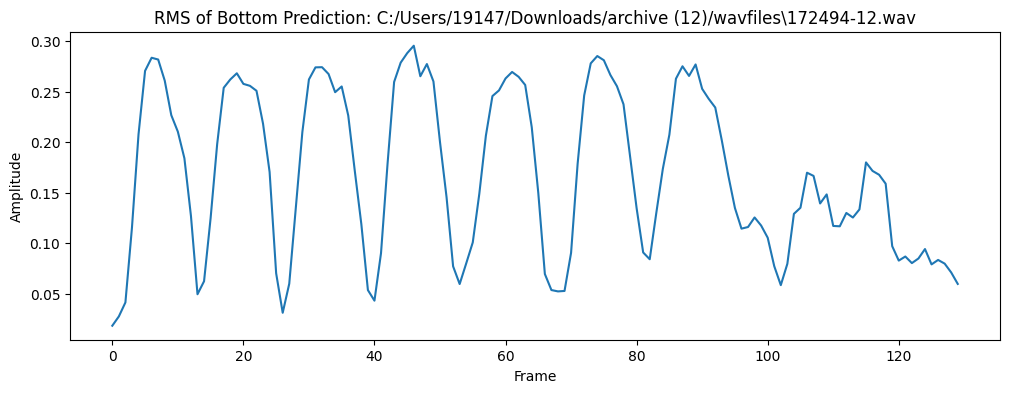

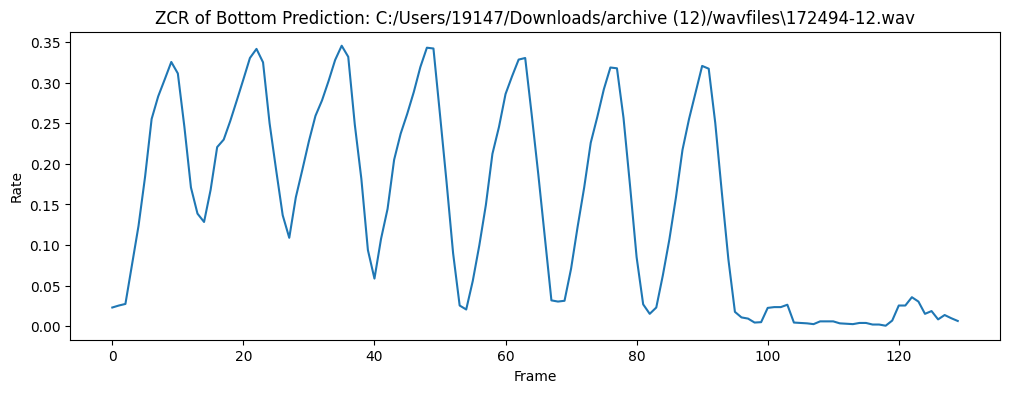

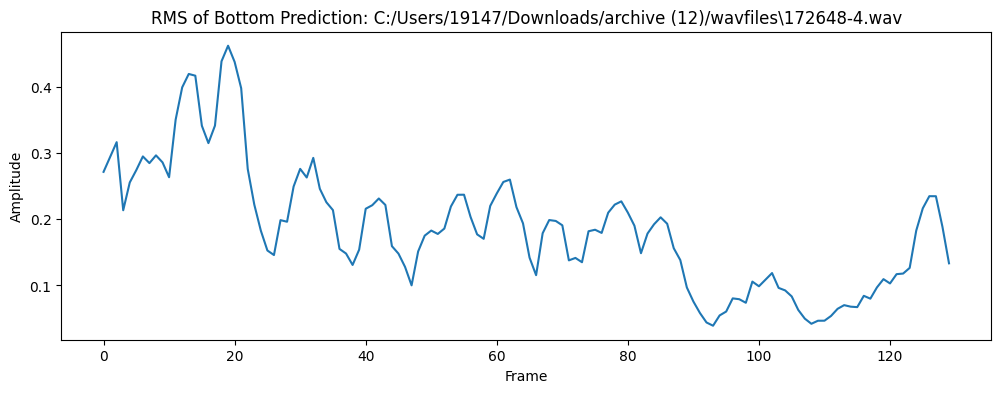

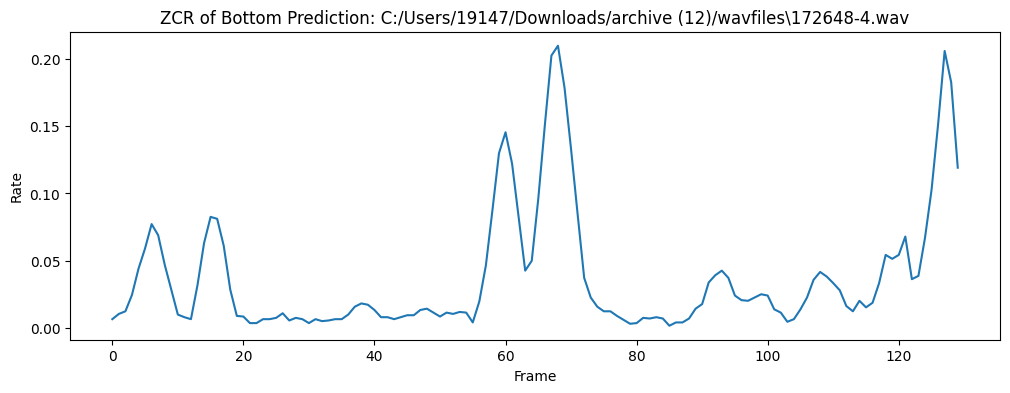

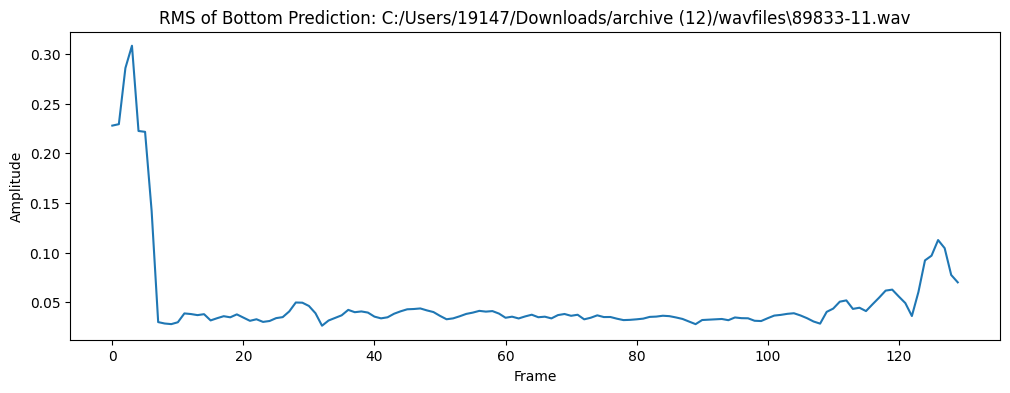

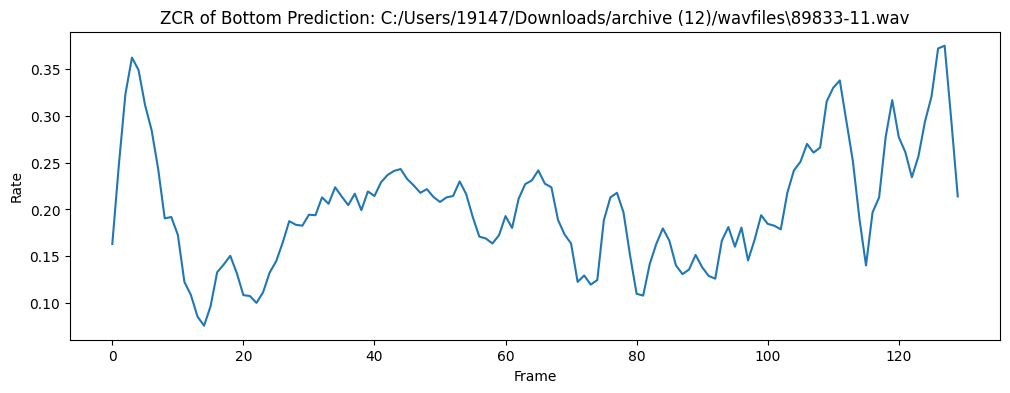

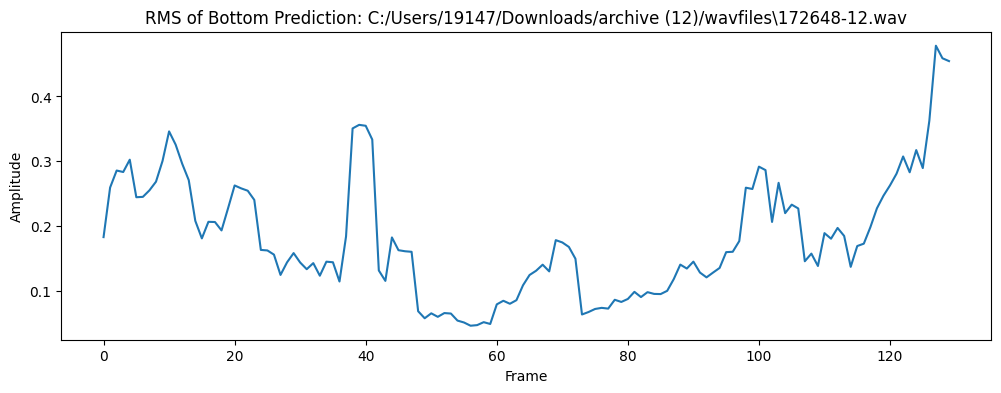

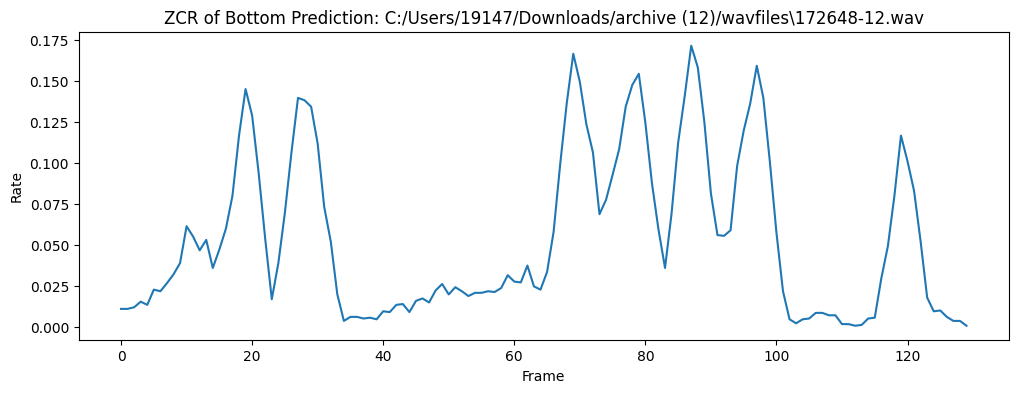

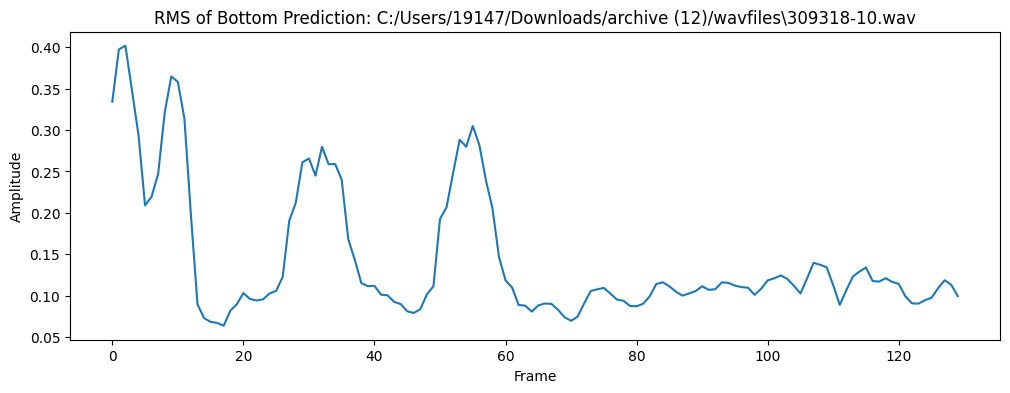

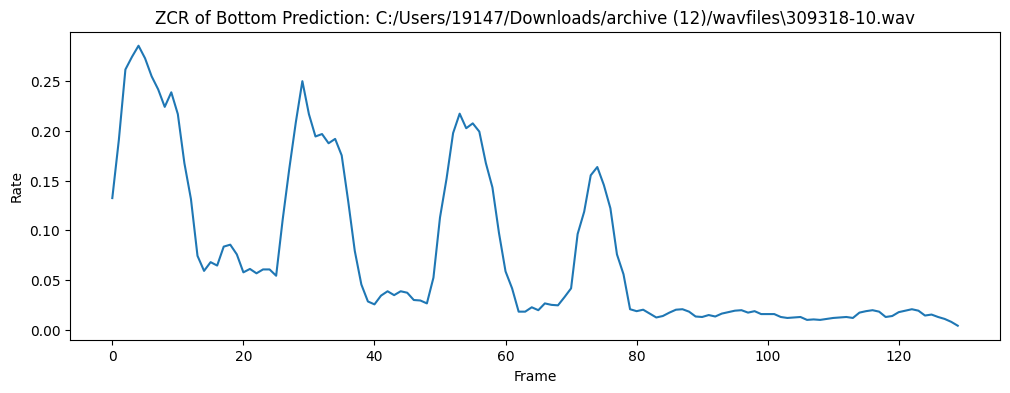

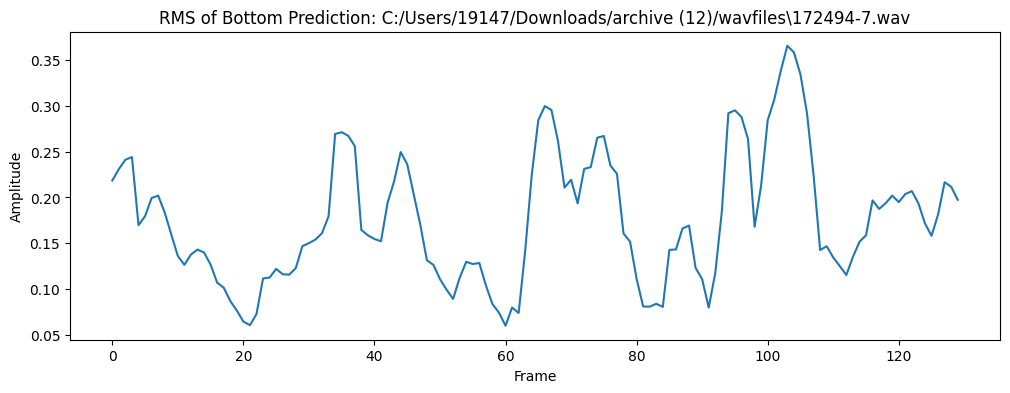

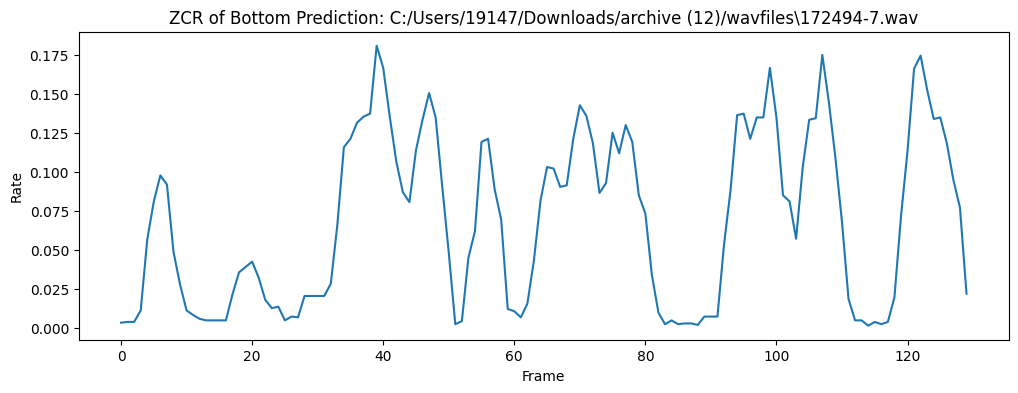

In [19]:
# Bottom Predictions
for index in waveform_bottom_indices:
    features = X2_test[index]
    file_path = files2_test[index]
    plot_combined_features(features, f'Bottom Prediction: {file_path}')



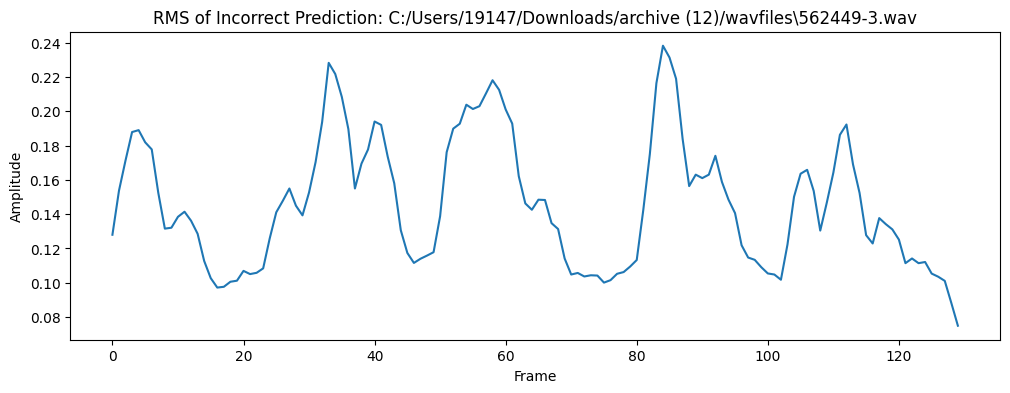

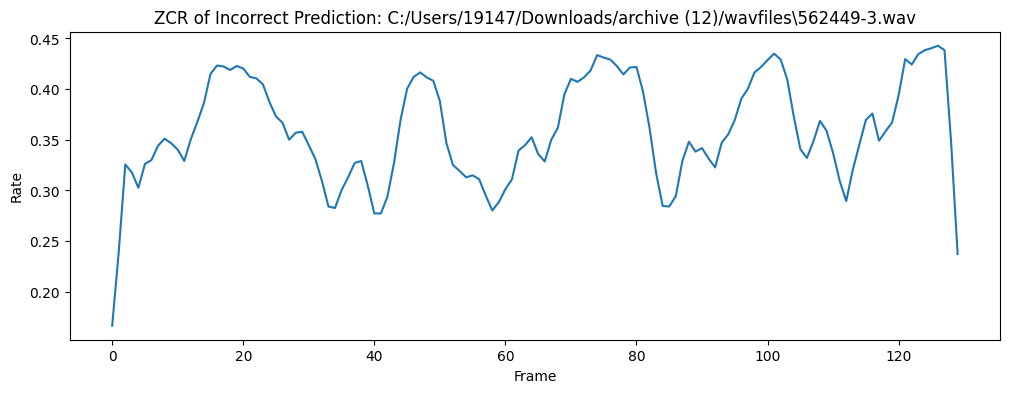

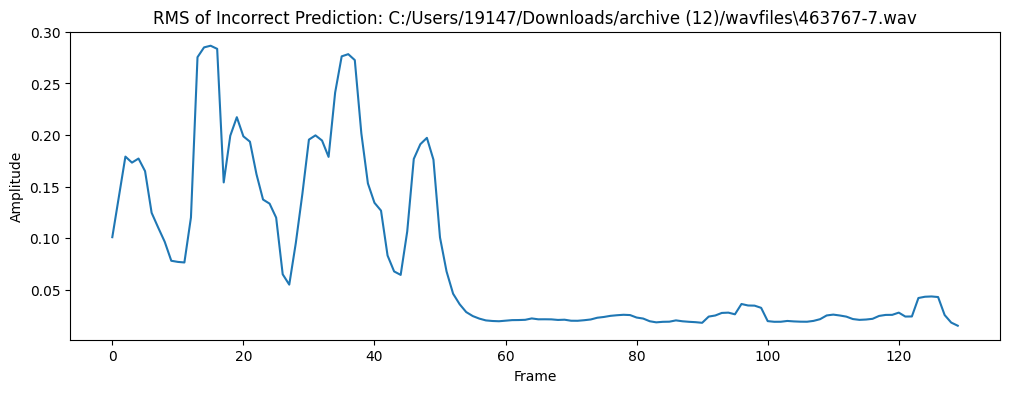

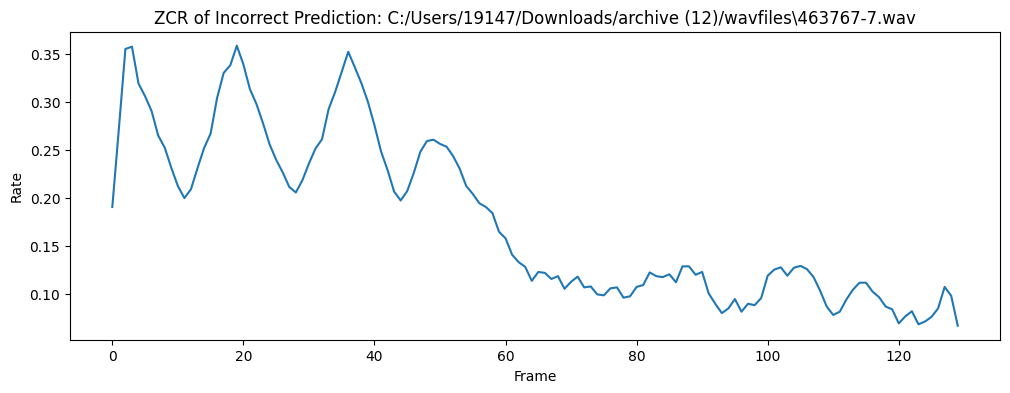

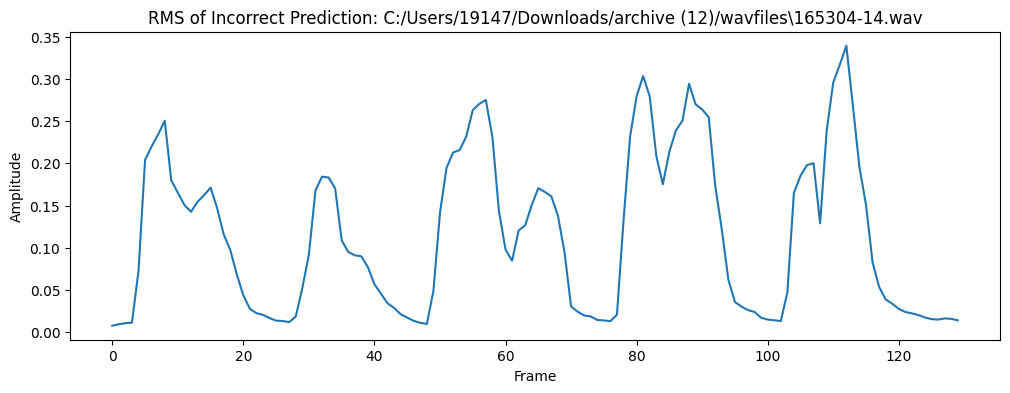

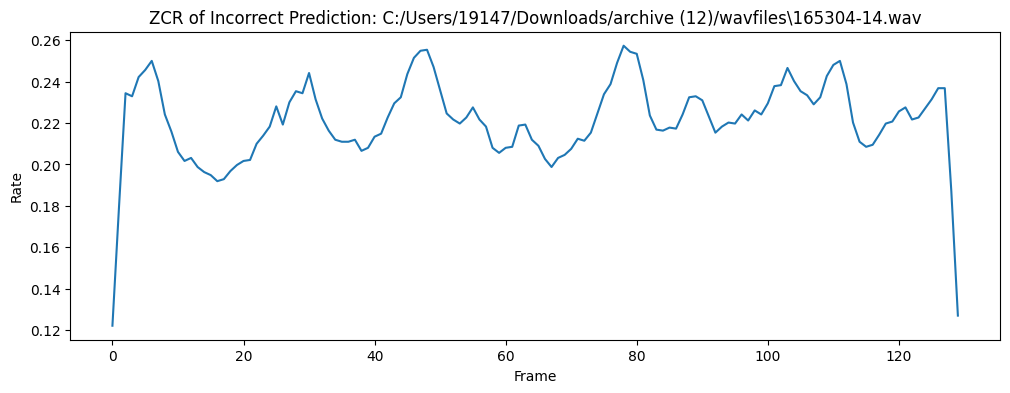

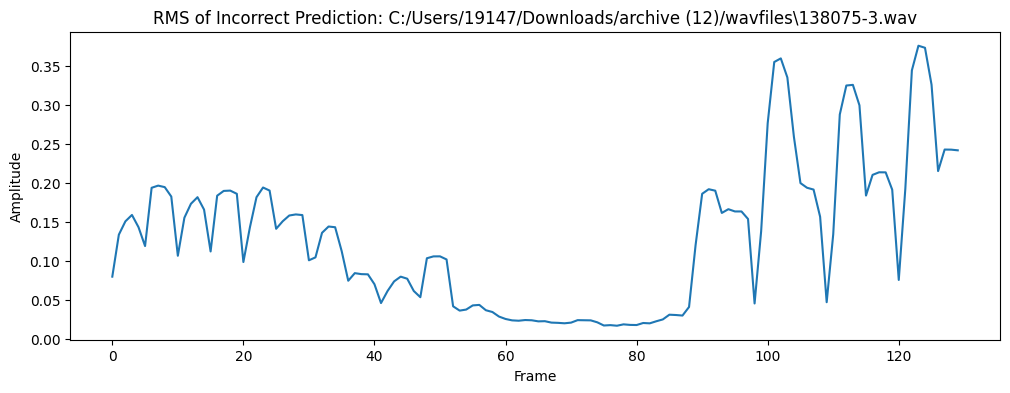

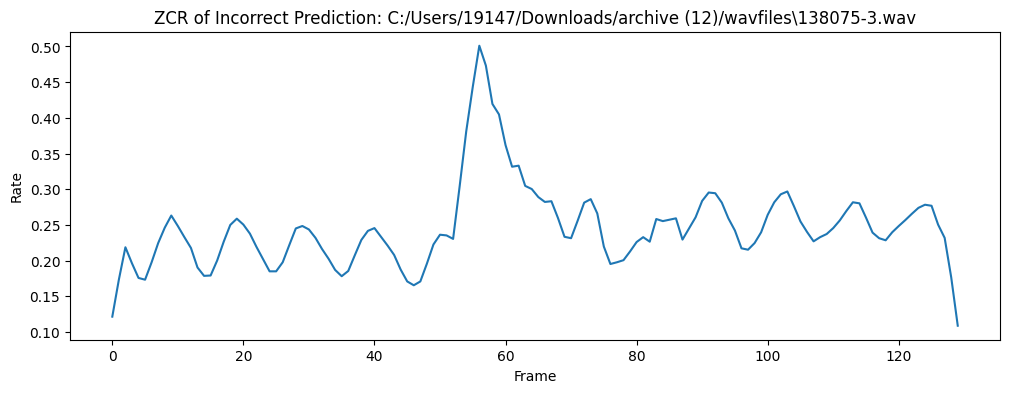

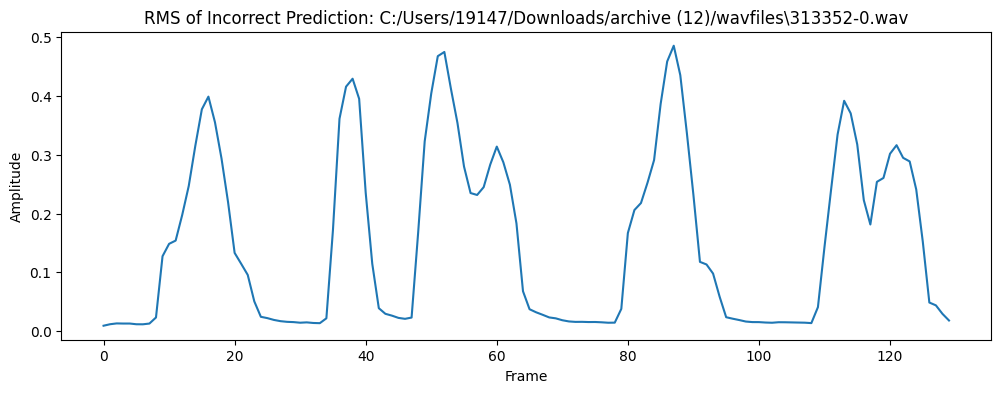

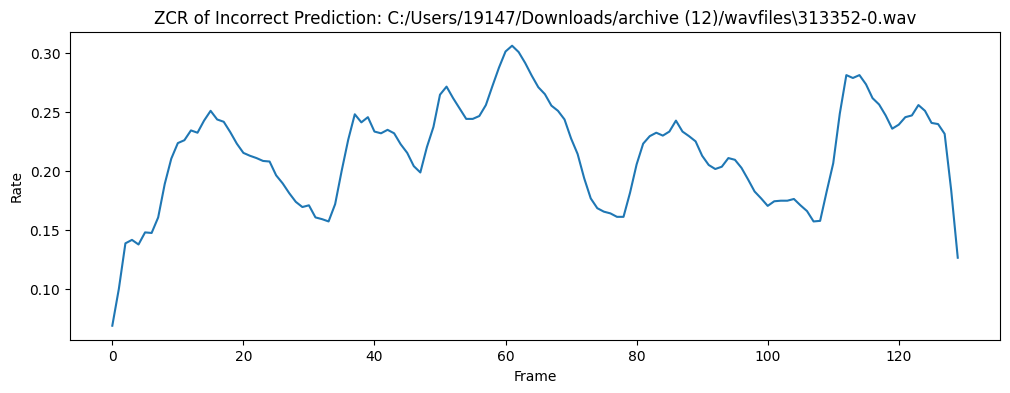

In [20]:
number_to_display = 5  

for index in waveform_incorrect_indices[:number_to_display]:
    features = X2_test[index]
    file_path = files2_test[index]
    plot_title = f'Incorrect Prediction: {file_path}'
    plot_combined_features(features, plot_title)

In [26]:
# Create the SHAP explainer object with your model
explainer = shap.TreeExplainer(clf_waveform)

# Calculate SHAP values for the training set
shap_values = explainer.shap_values(X2_train)

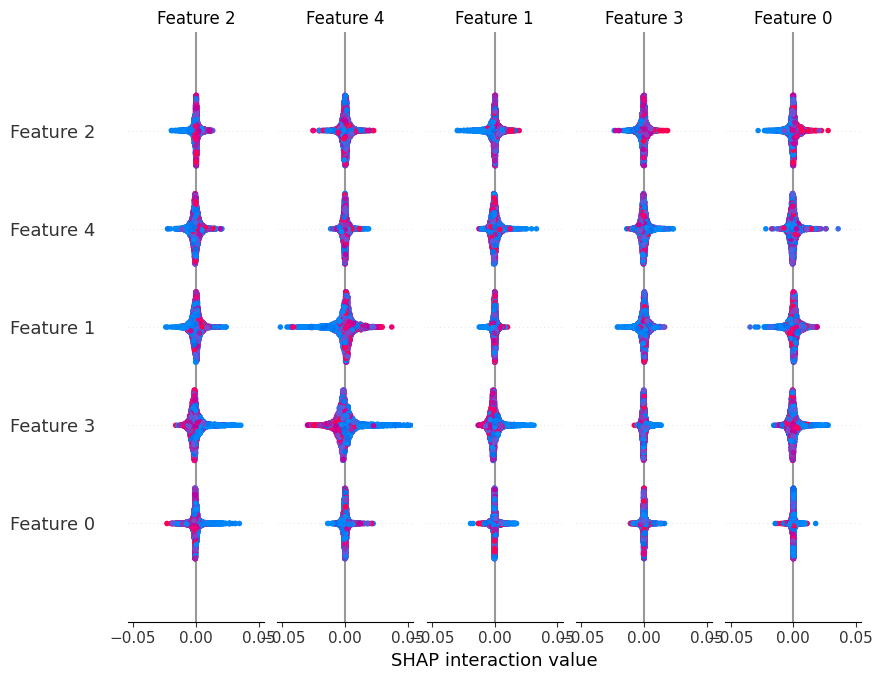

In [29]:
shap.initjs()
# Create a standard SHAP summary plot (not just the bar chart)
shap.summary_plot(shap_values, X2_train)

shap.force_plot(explainer.expected_value[0], shap_values[0, :, 0], X2_train[0, :])
